# The Battle of Neighbourhoods - Finding a Better Place in Scarborough, Toronto

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from pandas import json_normalize
import folium
!pip install geocoder
import geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

print('\n\nAll imported successfully')

     |████████████████████████████████| 102kB 3.8MB/s 


All imported successfully


## Data Extracting and Cleaning
Using pandas to scrap list of postal codes of given Wikipedia Page. 

Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables=pd.read_html(url)
data=pd.DataFrame(tables[0])
data.head(3)

,0,1,2,3,4,5,6,7,8
0,M1ANot assigned,M2ANot assigned,M3ANorth York(Parkwoods),M4ANorth York(Victoria Village),M5ADowntown Toronto(Regent Park / Harbourfront),M6ANorth York(Lawrence Manor / Lawrence Heights),M7AQueen's Park(Ontario Provincial Government),M8ANot assigned,M9AEtobicoke(Islington Avenue)
1,M1BScarborough(Malvern / Rouge),M2BNot assigned,M3BNorth York(Don Mills)North,M4BEast York(Parkview Hill / Woodbine Gardens),"M5BDowntown Toronto(Garden District, Ryerson)",M6BNorth York(Glencairn),M7BNot assigned,M8BNot assigned,M9BEtobicoke(West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
2,M1CScarborough(Rouge Hill / Port Union / Highland Creek),M2CNot assigned,M3CNorth York(Don Mills)South(Flemingdon Park),M4CEast York(Woodbine Heights),M5CDowntown Toronto(St. James Town),M6CYork(Humewood-Cedarvale),M7CNot assigned,M8CNot assigned,M9CEtobicoke(Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood)


Since I am only interested with Scarborough, I discarded the rest of the boroughs from the scraped data and processing only the Scarborough data.

In [3]:
a=list()
for r in np.arange(data.shape[0]):
  for c in np.arange(data.shape[1]):
    element=data.iloc[r,c]
    if element.find('Scarborough')!=-1:
      a.append(element)

In [4]:
row_list=[]
for i in a:
  code=i[:3]
  x=i[3:].split('(')
  borough=x[0]
  x=x[1][:-1]
  neighbourhood=x.replace('/',',')
  dict1 = {'PostalCode':code,'Borough':borough,'Neighbourhood':neighbourhood}
  row_list.append(dict1)

data=pd.DataFrame(row_list)
print('Any NULL value? ',data.isna().any().any())
print('Data shape: ',data.shape)
data.head()

Any NULL value?  False
Data shape:  (17, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Function to get latitude and logintude data.

In [5]:
def get_latilong(postal_code):
    lati_long_coords=None
    while(lati_long_coords is None):
        g=geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords=g.latlng
    return lati_long_coords

get_latilong('M1B')

[43.811390000000074, -79.19661999999994]

In [6]:
# Retrieving Postal Code Co-ordinates
postal_codes=data['PostalCode']    
coords=[get_latilong(postal_code) for postal_code in postal_codes.tolist()]

In [7]:
# Adding Columns Latitude & Longitude
df_coords=pd.DataFrame(coords,columns=['Latitude','Longitude'])
data['Latitude']=df_coords['Latitude']
data['Longitude']=df_coords['Longitude']
data.sample(3)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
6,M1K,Scarborough,"Kennedy Park , Ionview , East Birchmount Park",43.72582,-79.26461
15,M1W,Scarborough,"Steeles West , L'Amoreaux West",43.80079,-79.32162
11,M1R,Scarborough,"Wexford , Maryvale",43.75075,-79.30054


## Map of Scarborough and it's neighbourhoods

In [8]:
address='Scarborough,Toronto'
geolocator=Nominatim(user_agent='scarborough-explorer')
location=geolocator.geocode(address)
lat_sb=location.latitude
lon_sb=location.longitude

map_scarborough=folium.Map(location=[lat_sb,lon_sb],zoom_start=11)
for lat,lon,ngh in zip(data['Latitude'],data['Longitude'],data['Neighbourhood']):
  label=folium.Popup(ngh,parse_html=True)
  folium.CircleMarker(
      [lat,lon],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7,
      parse_html=False).add_to(map_scarborough)

map_scarborough

Foursquare credentials

In [9]:
CLIENT_ID='LD5VPYYDBARIR2GVKJ0Z5WTUUPKIFKSPKBGOVQGUMBDNC1ZA'
CLIENT_SECRET='PVO1MKS1A0M2ISJQP2X255142AE2KNBZLEEV45O0X00OJW4N'
VERSION='20180605'
LIMIT=100
RADIUS=500

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
# function to explore each neighbourhood and get the venues in a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
scarborough_venues=getNearbyVenues(data['Neighbourhood'],data['Latitude'],data['Longitude'])
scarborough_venues.sample(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
132,"Cliffside , Cliffcrest , Scarborough Village West",43.72360,-79.23496,TD Canada Trust,43.727473,-79.229293,Bank
109,"Golden Mile , Clairlea , Oakridge",43.71289,-79.28506,Clairlea Futbol Centre,43.715234,-79.286506,Soccer Field
172,"Dorset Park , Wexford Heights , Scarborough Town Centre",43.75998,-79.26940,Salvation Army Thrift Store,43.755782,-79.276208,Thrift / Vintage Store
320,"Steeles West , L'Amoreaux West",43.80079,-79.32162,Nicey's Takeout,43.798579,-79.332389,Caribbean Restaurant
339,"Steeles West , L'Amoreaux West",43.80079,-79.32162,Pharmacy Ave. & Finch Ave. E,43.794371,-79.325858,Intersection


Let's check how many venues were returned for each neighborhood


In [14]:
scarborough_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,43,43,43,43,43,43
"Birch Cliff , Cliffside West",16,16,16,16,16,16
Cedarbrae,20,20,20,20,20,20
"Clarks Corners , Tam O'Shanter , Sullivan",38,38,38,38,38,38
"Cliffside , Cliffcrest , Scarborough Village West",12,12,12,12,12,12
"Dorset Park , Wexford Heights , Scarborough Town Centre",30,30,30,30,30,30
"Golden Mile , Clairlea , Oakridge",21,21,21,21,21,21
"Guildwood , Morningside , West Hill",19,19,19,19,19,19
"Kennedy Park , Ionview , East Birchmount Park",22,22,22,22,22,22


In [15]:
print(f"There is a total of {len(scarborough_venues['Venue'].unique())} venues in the Scarborough.")
print(f"There is {len(scarborough_venues['Venue Category'].unique())} unique venue categories.")

There is a total of 273 venues in the Scarborough.
There is 106 unique venue categories.


## One Hot Encoding of Features

In [16]:
scarborough_onehot=pd.get_dummies(scarborough_venues['Venue Category'],prefix='',prefix_sep='')
scarborough_onehot['Neighbourhood']=scarborough_venues['Neighbourhood'] 
fixed_columns=[scarborough_onehot.columns[-1]]+list(scarborough_onehot.columns[:-1])
scarborough_onehot=scarborough_onehot[fixed_columns]
print('New data shape: ',scarborough_onehot.shape)
scarborough_onehot.head()

New data shape:  (345, 107)


,Neighbourhood,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Beer Store,Big Box Store,Bistro,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,...,Malay Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Nail Salon,Newsagent,Noodle House,Other Great Outdoors,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pool Hall,Pub,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Sports Bar,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Zoo Exhibit
0,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
scarborough_grouped = scarborough_onehot.groupby('Neighbourhood').mean().reset_index()
scarborough_grouped.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bank,Beer Store,Big Box Store,Bistro,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,College Stadium,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,...,Malay Restaurant,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Music Store,Nail Salon,Newsagent,Noodle House,Other Great Outdoors,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pool Hall,Pub,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Spa,Sports Bar,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Zoo Exhibit
0,Agincourt,0.0,0.0,0.00,0.0,0.023256,0.023256,0.023256,0.000000,0.0,0.000000,0.023256,0.023256,0.00,0.000000,0.00,0.0,0.000000,0.0000,0.023256,0.000000,0.209302,0.046512,0.0000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0000,0.023256,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,...,0.023256,0.023256,0.0,0.000000,0.0,0.00,0.0,0.023256,0.023256,0.0,0.023256,0.000000,0.023256,0.023256,0.023256,0.023256,0.0,0.0,0.023256,0.046512,0.023256,0.0,0.093023,0.0,0.023256,0.0,0.0,0.0,0.000000,0.0,0.023256,0.023256,0.000000,0.000000,0.0,0.0,0.0,0.023256,0.0,0.0
1,"Birch Cliff , Cliffside West",0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.0625,0.0,0.062500,0.000000,0.0,0.0625,0.0,0.0625,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.062500,0.000000,0.000000,0.0,0.000000,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.062500,0.0,0.0,0.0,0.000000,0.0,0.0
2,Cedarbrae,0.0,0.0,0.05,0.0,0.000000,0.050000,0.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.05,0.000000,0.05,0.0,0.000000,0.0000,0.000000,0.050000,0.050000,0.100000,0.0000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.05,0.0,0.050000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.05,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.050000,0.0,0.0,0.0,0.000000,0.0,0.0
3,"Clarks Corners , Tam O'Shanter , Sullivan",0.0,0.0,0.00,0.0,0.000000,0.026316,0.052632,0.026316,0.0,0.000000,0.000000,0.000000,0.00,0.026316,0.00,0.0,0.026316,0.0000,0.026316,0.026316,0.052632,0.026316,0.0000,0.0,0.026316,0.026316,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.078947,0.0,0.00,0.0,0.026316,0.0,0.0,...,0.000000,0.000000,0.0,0.026316,0.0,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.026316,0.026316,0.026316,0.000000,0.000000,0.0,0.0,0.052632,0.026316,0.000000,0.0,0.026316,0.0,0.000000,0.0,0.0,0.0,0.026316,0.0,0.000000,0.000000,0.026316,0.026316,0.0,0.0,0.0,0.052632,0.0,0.0
4,"Cliffside , Cliffcrest , Scarborough Village West",0.0,0.0,0.00,0.0,0.000000,0.000000,0.083333,0.000000,0.0,0.083333,0.000000,0.000000,0.00,0.000000,0.00,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.083333,0.0000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.083333,0.000000,0.166667,0.083333,0.000000,0.000000,0.0,0.0,0.083333,0.083333,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most common venues near neighbourhoods

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = scarborough_grouped['Neighbourhood']

for ind in np.arange(scarborough_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(scarborough_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Coffee Shop,Sandwich Place,Newsagent,Pool Hall,Pool,Pizza Place,Pharmacy,Park
1,"Birch Cliff , Cliffside West",Park,Skating Rink,General Entertainment,Convenience Store,College Stadium,Diner,Restaurant,Café,Dessert Shop,Gym Pool
2,Cedarbrae,Indian Restaurant,Coffee Shop,Hakka Restaurant,Burger Joint,Music Store,Flower Shop,Fried Chicken Joint,Chinese Restaurant,Caribbean Restaurant,Gas Station
3,"Clarks Corners , Tam O'Shanter , Sullivan",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Intersection,Bank,Chinese Restaurant,Convenience Store,Pizza Place,Pharmacy,Pet Store
4,"Cliffside , Cliffcrest , Scarborough Village West",Ice Cream Shop,Pharmacy,Gift Shop,Coffee Shop,Sandwich Place,Park,Restaurant,Bank,Pizza Place,Bistro


## Cluster Neighborhoods

In [20]:
# Using K-Means to cluster neighborhood into 4 clusters
scarborough_grouped_clustering = scarborough_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(scarborough_grouped_clustering)
kmeans.labels_

array([1, 2, 1, 1, 2, 1, 1, 2, 1, 3, 1, 0, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [21]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
scarborough_merged=data
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
scarborough_merged = scarborough_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
scarborough_merged.dropna(inplace=True)
scarborough_merged.head(3)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern , Rouge",43.81139,-79.19662,3.0,Zoo Exhibit,Trail,Fast Food Restaurant,Construction & Landscaping,Hobby Shop,BBQ Joint,Badminton Court,Diner,Discount Store,Electronics Store
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.78574,-79.15875,0.0,Park,Italian Restaurant,Breakfast Spot,Burger Joint,Gaming Cafe,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Fast Food Restaurant
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.76575,-79.17470,2.0,Park,Pharmacy,Coffee Shop,Smoothie Shop,Gymnastics Gym,Pizza Place,Discount Store,Fast Food Restaurant,Restaurant,Food & Drink Shop


## Map of Clusters

In [22]:
kclusters = 4
# create map
map_clusters = folium.Map(location=[lat_sb, lon_sb], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(scarborough_merged['Latitude'], 
                                   scarborough_merged['Longitude'], 
                                   scarborough_merged['Neighbourhood'], 
                                   scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']


## Different Clusters

In [23]:
df1=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 0,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
df2=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 1,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
df3=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 2,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]
df4=scarborough_merged.loc[scarborough_merged['Cluster Labels'] == 3,scarborough_merged.columns[[2] + list(range(5, scarborough_merged.shape[1]))]]

## Neighbourhood scores on their top 10 venues

In [24]:
def sum_of_top_10_venue_score(row):
  row=row.to_list()
  row.sort(reverse=True)
  return sum(row[:10])

In [25]:
l=scarborough_grouped.iloc[:,1:].T.apply(sum_of_top_10_venue_score)
l=list(l)
scarborough_grouped_score=pd.DataFrame(scarborough_grouped['Neighbourhood'])
scarborough_grouped_score['Score']=l

In [26]:
df1=df1.merge(scarborough_grouped_score,how='left',on='Neighbourhood')
df2=df2.merge(scarborough_grouped_score,how='left',on='Neighbourhood')
df3=df3.merge(scarborough_grouped_score,how='left',on='Neighbourhood')
df4=df4.merge(scarborough_grouped_score,how='left',on='Neighbourhood')

In [27]:
df1.sort_values(by='Score',ascending=False,inplace=True)
df2.sort_values(by='Score',ascending=False,inplace=True)
df3.sort_values(by='Score',ascending=False,inplace=True)
df4.sort_values(by='Score',ascending=False,inplace=True)

In [28]:
df1

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
0,"Rouge Hill , Port Union , Highland Creek",0.0,Park,Italian Restaurant,Breakfast Spot,Burger Joint,Gaming Cafe,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Fast Food Restaurant,1.0


In [29]:
df2

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
2,Scarborough Village,1.0,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Convenience Store,Indian Restaurant,Coffee Shop,Big Box Store,Chinese Restaurant,Restaurant,Fried Chicken Joint,1.000000
0,Woburn,1.0,Indian Restaurant,Fast Food Restaurant,Park,Pizza Place,Supermarket,Department Store,Juice Bar,Discount Store,Chinese Restaurant,Sandwich Place,0.833333
3,"Kennedy Park , Ionview , East Birchmount Park",1.0,Chinese Restaurant,Bus Line,Discount Store,Pizza Place,Grocery Store,Coffee Shop,Hobby Shop,Department Store,Pharmacy,Fast Food Restaurant,0.818182
9,"Milliken , Agincourt North , Steeles East , L'Amoreaux East",1.0,Chinese Restaurant,Park,Pharmacy,BBQ Joint,Bakery,Dim Sum Restaurant,Shop & Service,Caribbean Restaurant,Shopping Plaza,Pizza Place,0.750000
1,Cedarbrae,1.0,Indian Restaurant,Coffee Shop,Hakka Restaurant,Burger Joint,Music Store,Flower Shop,Fried Chicken Joint,Chinese Restaurant,Caribbean Restaurant,Gas Station,0.700000
5,"Dorset Park , Wexford Heights , Scarborough Town Centre",1.0,Electronics Store,Chinese Restaurant,Restaurant,Indian Restaurant,Furniture / Home Store,Bakery,Pizza Place,Coffee Shop,Park,Intersection,0.666667
10,"Steeles West , L'Amoreaux West",1.0,Fast Food Restaurant,Intersection,Pharmacy,Pizza Place,Chinese Restaurant,Sandwich Place,Gym Pool,Nail Salon,Other Great Outdoors,Liquor Store,0.629630
6,"Wexford , Maryvale",1.0,Middle Eastern Restaurant,Grocery Store,Pizza Place,Intersection,Burger Joint,Dessert Shop,Fish Market,Coffee Shop,Chinese Restaurant,Korean Restaurant,0.606061
4,"Golden Mile , Clairlea , Oakridge",1.0,Intersection,Bakery,Park,Convenience Store,Coffee Shop,Pharmacy,Pizza Place,Fast Food Restaurant,Pub,Sandwich Place,0.571429
7,Agincourt,1.0,Chinese Restaurant,Shopping Mall,Coffee Shop,Sandwich Place,Newsagent,Pool Hall,Pool,Pizza Place,Pharmacy,Park,0.534884


In [30]:
df3

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
1,"Cliffside , Cliffcrest , Scarborough Village West",2.0,Ice Cream Shop,Pharmacy,Gift Shop,Coffee Shop,Sandwich Place,Park,Restaurant,Bank,Pizza Place,Bistro,1.000000
2,"Birch Cliff , Cliffside West",2.0,Park,Skating Rink,General Entertainment,Convenience Store,College Stadium,Diner,Restaurant,Café,Dessert Shop,Gym Pool,0.812500
0,"Guildwood , Morningside , West Hill",2.0,Park,Pharmacy,Coffee Shop,Smoothie Shop,Gymnastics Gym,Pizza Place,Discount Store,Fast Food Restaurant,Restaurant,Food & Drink Shop,0.631579


In [31]:
df4

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
0,"Malvern , Rouge",3.0,Zoo Exhibit,Trail,Fast Food Restaurant,Construction & Landscaping,Hobby Shop,BBQ Joint,Badminton Court,Diner,Discount Store,Electronics Store,1.0


## Comparision of the neighbourhoods

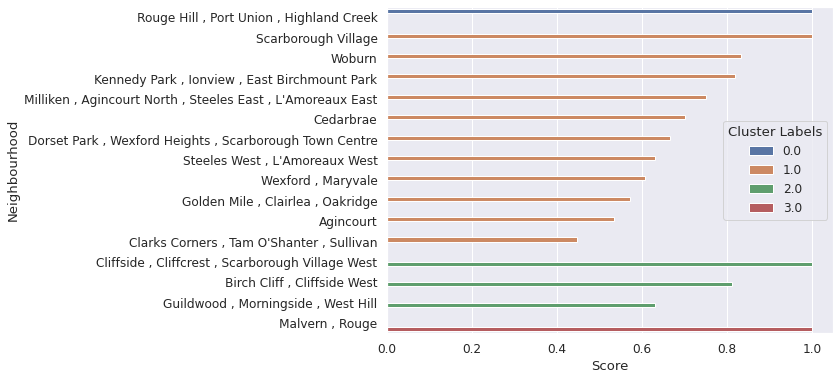

In [58]:
new_data=scarborough_merged.merge(scarborough_grouped_score,how='left',on='Neighbourhood')
new_data.sort_values(by=['Cluster Labels','Score'],ascending=[True,False],inplace=True)
fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale = 1.1)
sns.barplot(x='Score',y='Neighbourhood',data=new_data,hue='Cluster Labels',ax=ax)